In [90]:
#Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

In [91]:
# Specify the correct dtype using the updated argument name
schema_overrides = {
    "Applicant License #": pl.Utf8  # or another appropriate type
}

# Read CSV with error handling
df = pl.read_csv(
    '/Users/josemiguelvilchesfierro/Documents/UpWork/Work/Real_states_NY/Permits_approval/Source/DOB_Job_Application_Filings_20241010.csv',
    schema_overrides=schema_overrides,
    ignore_errors=True,
    null_values=["H65055"]
)

# To get similar info as pandas' df.info()

In [92]:
# Convert Polars DataFrame to pandas DataFrame
df_pandas = df.to_pandas()

In [43]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2709553 entries, 0 to 2709552
Data columns (total 96 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Job #                          int64  
 1   Doc #                          int64  
 2   Borough                        object 
 3   House #                        object 
 4   Street Name                    object 
 5   Block                          float64
 6   Lot                            float64
 7   Bin #                          int64  
 8   Job Type                       object 
 9   Job Status                     object 
 10  Job Status Descrp              object 
 11  Latest Action Date             object 
 12  Building Type                  object 
 13  Community - Board              float64
 14  Cluster                        object 
 15  Landmarked                     object 
 16  Adult Estab                    object 
 17  Loft Board                     object 
 18  Ci

In [83]:
# Convert 'Pre- Filing Date' to datetime using .loc to avoid SettingWithCopyWarning
df_pandas['Date_Approved'] = pd.to_datetime(df_pandas['Approved'], format='%d/%m/%Y', errors='coerce')

# Filter the dataframe for the years 2023 and 2024
df_filtered = df_pandas[df_pandas['Date_Approved'].dt.year.isin([2023, 2024])]

# Check if df_filtered is empty
if df_filtered.empty:
    print("The filtered DataFrame is empty. Check the filtering conditions.")
else:
    # Group the data and calculate the mean
    grouped_df = df_filtered.groupby(
        ['Borough','Job Type','Job Status','Approved','Job #','Building Type','Pre- Filing Date','BUILDING_CLASS','Job Description','Date_Approved','Fully Paid'],
    ).agg({
        'GIS_LATITUDE': 'mean',
        'GIS_LONGITUDE': 'mean',
        'Initial Cost': 'sum',
    }).reset_index()


In [84]:
# Export the grouped DataFrame to a CSV file
grouped_df.to_csv('/Users/josemiguelvilchesfierro/Documents/UpWork/Work/Real_states_NY/Permits_approval/output/job_application_filings_output.csv', index=False)

In [85]:
grouped_df

,Borough,Job Type,Job Status,Job #,Building Type,Pre- Filing Date,BUILDING_CLASS,Job Description,Date_Approved,Fully Paid,GIS_LATITUDE,GIS_LONGITUDE
0,BRONX,A1,P,220705468,OTHERS,2020-03-17,G2,PROPOSED CHANGE FROM PLUMBING SHOP (USE GROUP ...,2023-06-04,03/17/2020,40.839520,-73.920499
1,BRONX,A1,P,220739672,1-2-3 FAMILY,2021-12-23,B1,NO WORK ALT1 APPLICATION TO ESTABLISH THE NEW ...,2023-02-05,12/23/2021,40.839668,-73.889808
2,BRONX,A1,P,220740615,1-2-3 FAMILY,2021-08-31,B2,APPLICATION FILED TO SECURE A CERTIFICATE FOR ...,2024-08-07,08/31/2021,40.886408,-73.833392
3,BRONX,A1,P,220742855,OTHERS,2024-01-31,O2,ALT 1 NO WORK FILED HEREWITH TO CHANGE USE FRO...,2024-05-03,01/31/2024,40.827967,-73.876176
4,BRONX,A1,P,220748733,OTHERS,2022-12-21,E1,THIS IS A NO WORK APPLICATION TO REVISE ZONING...,2023-12-04,12/21/2022,40.809891,-73.893044
...,...,...,...,...,...,...,...,...,...,...,...,...
5528,STATEN ISLAND,SI,U,520470286,OTHERS,2024-04-16,A2,EXISTING ZONING LOT (TAX LOT 34)TO BE SUBDIVID...,2024-06-05,04/16/2024,40.548418,-74.181044
5529,STATEN ISLAND,SI,U,520470295,OTHERS,2024-04-25,A1,EXISTING ZONING LOT (TAX LOT 5) TO BE SUBDIVID...,2024-10-05,04/25/2024,40.610651,-74.144515
5530,STATEN ISLAND,SI,U,520470302,OTHERS,2024-04-25,A1,EXISTING ZONING LOT TAX LOT 82)TO BE SUBDIVIDE...,2024-10-05,04/25/2024,40.546546,-74.139785
5531,STATEN ISLAND,SI,U,520470320,OTHERS,2024-02-06,V0,SUBDIVISION OF IMPROVED PROPERTY. ONE ZONING L...,2024-05-03,02/06/2024,40.529321,-74.197251


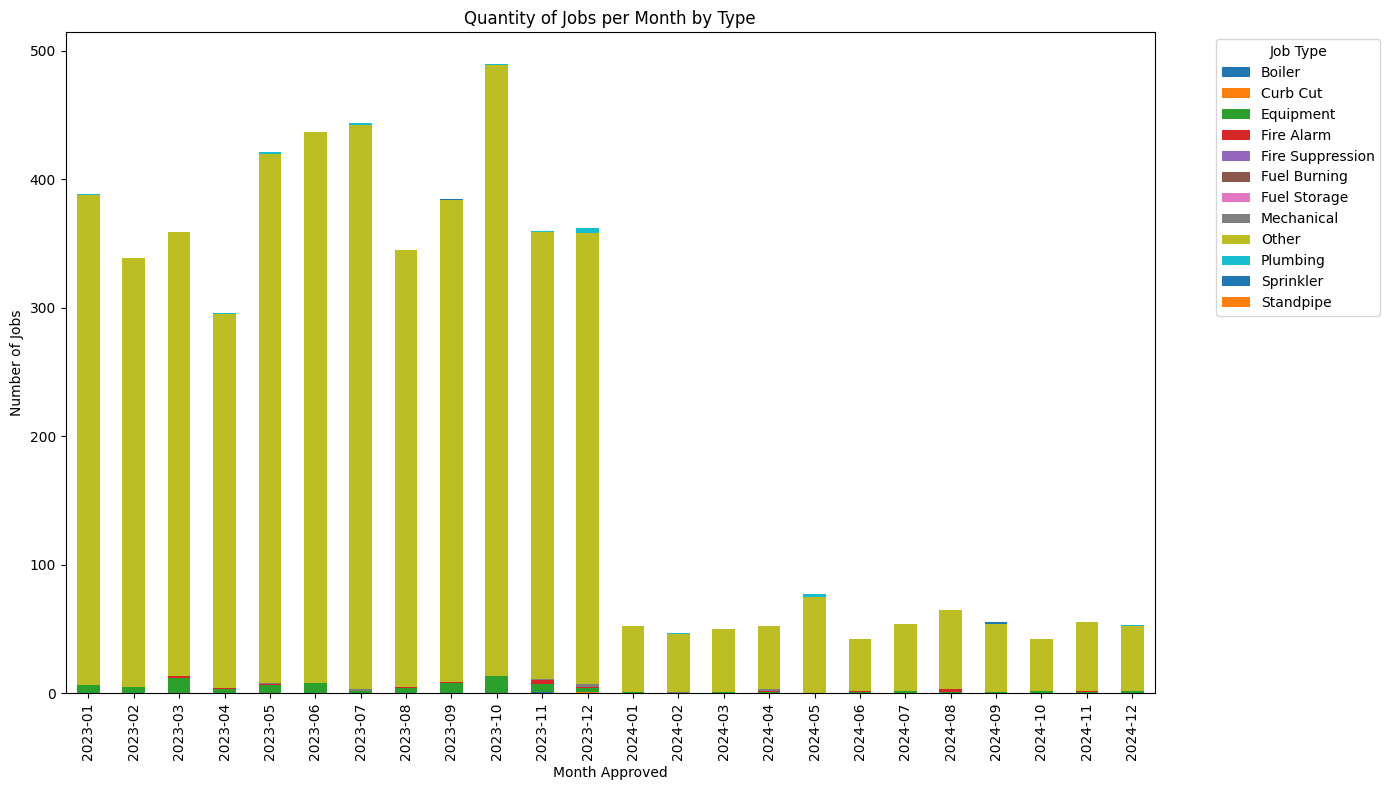

In [95]:
import matplotlib.pyplot as plt

# Extract the relevant columns and melt the DataFrame to have a long format
columns_of_interest = [
    'Plumbing', 'Mechanical', 'Boiler', 'Fuel Burning', 'Fuel Storage', 
    'Standpipe', 'Sprinkler', 'Fire Alarm', 'Equipment', 'Fire Suppression', 
    'Curb Cut', 'Other'
]
df_long = df_filtered.melt(id_vars=['Date_Approved'], value_vars=columns_of_interest, 
                           var_name='Job_Type', value_name='Count')

# Consider 'X' as yes and replace it with 1
df_long['Count'] = df_long['Count'].apply(lambda x: 1 if x == 'X' else 0)

# Drop rows with NaN values in 'Count' column
df_long = df_long.dropna(subset=['Count'])

# Group by month and job type, then count the occurrences
df_long['Month_Approved'] = df_long['Date_Approved'].dt.to_period('M')
monthly_counts = df_long.groupby(['Month_Approved', 'Job_Type'])['Count'].sum().unstack(fill_value=0)

# Plot the data
monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Quantity of Jobs per Month by Type')
plt.xlabel('Month Approved')
plt.ylabel('Number of Jobs')
plt.legend(title='Job Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [96]:
df_long

,Date_Approved,Job_Type,Count,Month_Approved
0,2023-05-06,Plumbing,0,2023-05
1,2023-07-06,Plumbing,0,2023-07
2,2023-05-06,Plumbing,0,2023-05
3,2023-01-11,Plumbing,0,2023-01
4,2023-04-12,Plumbing,0,2023-04
...,...,...,...,...
69511,2023-02-06,Other,1,2023-02
69512,2023-06-06,Other,1,2023-06
69513,2023-03-07,Other,1,2023-03
69514,2023-02-06,Other,1,2023-02
